<a href="https://colab.research.google.com/github/shimaaahmedd/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import numpy as np
import scipy
import pandas as pd
%matplotlib inline
import cv2
from pylab import *
from matplotlib import pyplot as plt
import PIL
from sklearn.cluster import KMeans
import os
import scipy.io
import matplotlib.image as mpimg
import glob
from sklearn.metrics.cluster import contingency_matrix
import math
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import SpectralClustering
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/imageSegmentation/BSR/BSDS500/data/images/test/'
path2='/content/drive/MyDrive/Colab Notebooks/imageSegmentation/BSR/BSDS500/data/groundTruth/test/'
files = os.listdir(path)
# for file in files[51:200]:
#   os.remove(file)

Mounted at /content/drive


In [ ]:
count=0
for f in files:
  if(count==50):
    break
  if(f!="Thumbs.db"):
    img = cv2.imread(path+f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x,y,z=img.shape
    vectorFlattened=img.reshape(x *y,z)
    plt.imshow(img)
    plt.show()
    count+=1
# trainImages=np.array(trainImages)  
# print(trainImages.shape)
# print(trainImages[0].shape)


# **2. Visualize the image and the ground truth segmentation** 

In [ ]:
trainImages=[]
data=[]  
count=0
for f in files:
  if(count==50):
    break
  if(f!="Thumbs.db"):
    img = cv2.imread(path+f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x,y,z=img.shape
    vectorFlattened=img.reshape(x *y,z)
    trainImages.append(vectorFlattened)
    plt.imshow(img)
    plt.show()
    f=f[:-4]
    matfile = scipy.io.loadmat(path2+f+'.mat', struct_as_record=True)
    ground=matfile['groundTruth']
    groundtruth=[]
    for i in np.squeeze(ground):
      groundtruth.append(i[0][0])
    data.append(groundtruth)
    count+=1

# **Ground truth segmentation**

In [ ]:
for k in range (0,len(data)):    
  print(f"Data:{k}")
  for j in range(0,len(data[k])):
    plt.imshow(data[k][j][1])
    plt.show()  

# **3. K-means algorithm**
between {3,5,7,9,11} clusters. Every color represents a certain group (cluster) of
pixels.

In [ ]:
def K_Means_Clustering(k,size):
  Tlabels=[]
  segmented_image5=[]
  count=0
  for f in files:
    if(count==size):
      break
    if(f!="Thumbs.db"):
      img = cv2.imread(path+f)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
      pixel_vals = img.reshape((-1,3))
      # Convert to float type
      pixel_vals = np.float32(pixel_vals)
      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
      retval, labels, centers = cv2.kmeans(pixel_vals,k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
      Tlabels.append(labels)
      # convert data into 8-bit values
      centers = np.uint8(centers)
      segmented_data = centers[labels.flatten()]
      count+=1
      if size == 5:
        segmented_image5.append(segmented_data.reshape((img.shape)))    
      else:
        # reshape data into the original image dimensions
        segmented_image = segmented_data.reshape((img.shape))
        plt.imshow(segmented_image)
        plt.title(f'The Segmented Image of k = {k} cluster')
        plt.show()
     
  return Tlabels,segmented_image5

# **Conditional Entropy**

In [ ]:
def Entropy(data,Tlabels):
  contingency=[]
  Tentropy=[]
  dataset_sum=[]
  for k in range (0,len(data)):    
    print(f"Data:{k}")
    for j in range(0,len(data[k])):
      c=contingency_matrix(data[k][j][0], Tlabels[k])
      cT=np.transpose(c)
      rowSum=cT.sum(axis=1)
      Tsum=np.sum(cT)
      entropy=0
      for i in range (len(cT)):
        h=0
        for n in range (len(cT[0])):
          if(cT[i][n]==0):
            continue
          x=cT[i][n]/rowSum[i]
          h=h-x*math.log2(x)
        entropy=entropy+(rowSum[i]/Tsum)*h
        h=0
      Tentropy.append(entropy)
      print(f"Total Entropy:{j} ",entropy) 
    avg=np.sum(Tentropy)/len(Tentropy)
    print(f"Average of Entropy:{avg}")
    Tentropy=[]
    dataset_sum.append(avg)
  data_avg=np.average(dataset_sum)
  print(f"Average of f-Entropy of all Dataset:{data_avg}")
  dataset_sum=[] 

# **F-measure**

In [ ]:
def f_measures(i,predLabels):
  contingency_total_matrix=[]
  f_measure=np.zeros((i,3)) #k=3 X 3
  tot_mes=[]
  dataset_sum=[]
  for k in range (0,len(data)): #50 data
    f_measure_sum=[] 
    print(f"Data:{k}")
    for j in range(0,len(data[k])): # 5 ground truth
      contingency=contingency_matrix(data[k][j][0], predLabels[k])
      contingency_transpose=contingency.T  #3X10
      sum_rows=np.sum(contingency_transpose,axis=1)
      sum_cols=np.sum(contingency_transpose,axis=0)
      max = np.amax(contingency_transpose, 1)
      for m in range(0,len(contingency_transpose)): #0:clusters of size 3
        maxCluster=max[m]                           #MAX value of each cluster
        for n in range(0,len(contingency_transpose[0])):  #):features of 10
          f_measure[m][0]=maxCluster/(sum_rows[m])  #percision
          f_measure[m][1]=maxCluster/(sum_cols[n])  #recall
          f_measure[m][2]=(2 *  f_measure[m][0] *  f_measure[m][1]) / ( f_measure[m][0] +  f_measure[m][1]) #f-measure
        
      sum_of_each_grnd=np.sum(f_measure,axis=0)[2]/i #r=3 sum of f-measures in our matrix of each ground image
      print(f"Total F_measure:{j} ",sum_of_each_grnd) 
      f_measure_sum.append(sum_of_each_grnd)
    average=np.average(f_measure_sum)
    print(f"Average of f-measures:{average}") #average f-measure 5 or more of grnd images matrices
    dataset_sum.append(average)
  data_avg=np.average(dataset_sum)
  print(f"Average of f-measures of all Dataset:{data_avg}")
  dataset_sum=[] 



In [ ]:
k = [3,5,7,9,11]
for i in range(len(k)):
  print(f"K-means:{k[i]}")
  Tlabels,segmented_image=K_Means_Clustering(k[i],50)
  Entropy(data,Tlabels)
  f_measures(k[i],np.array(Tlabels))

# **4. Big Picture**

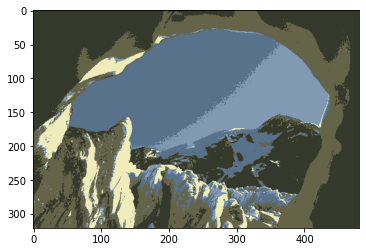

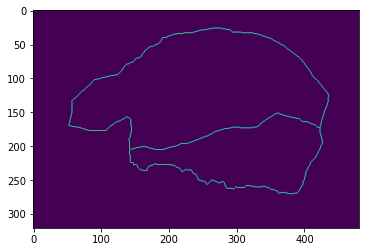

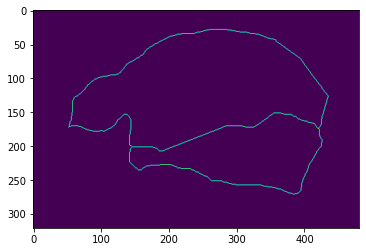

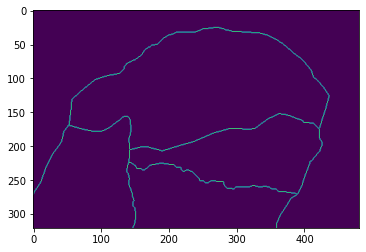

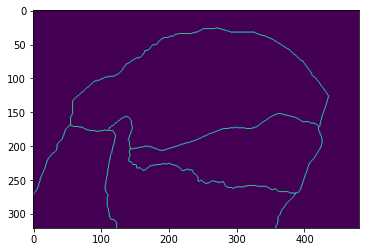

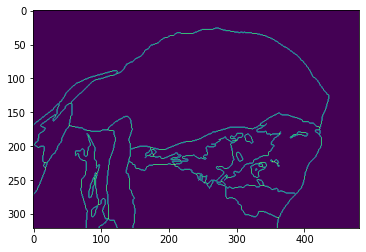

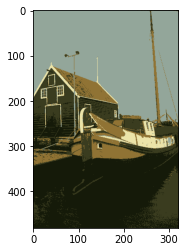

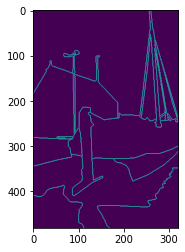

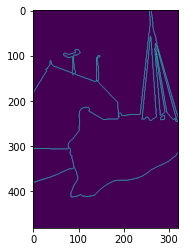

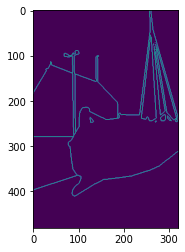

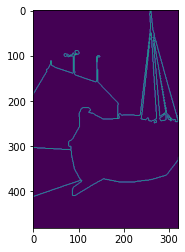

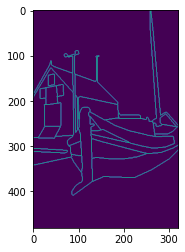

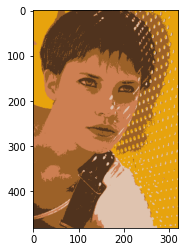

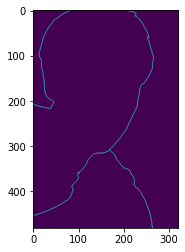

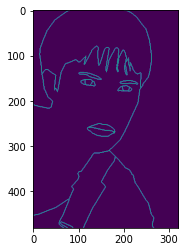

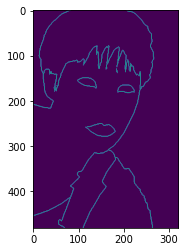

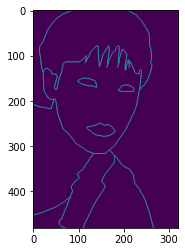

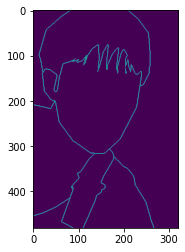

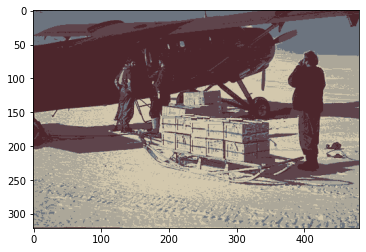

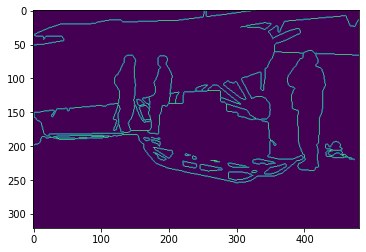

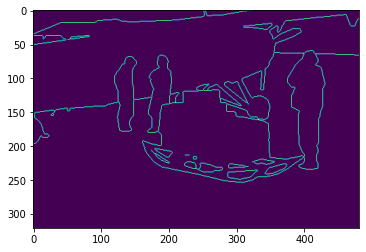

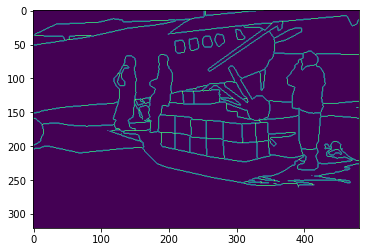

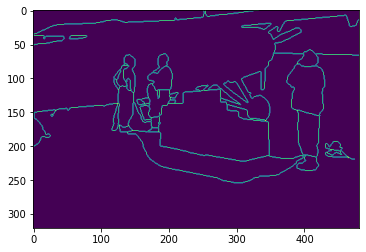

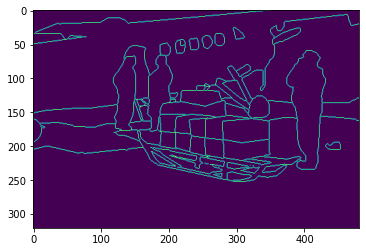

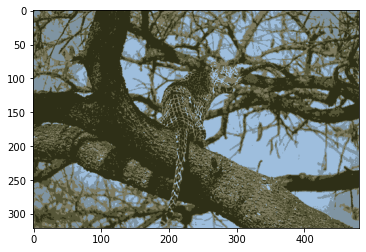

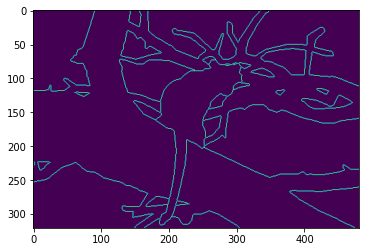

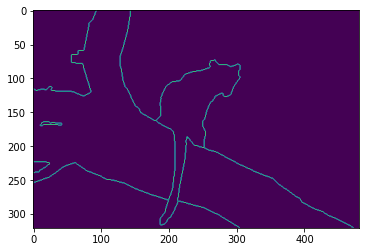

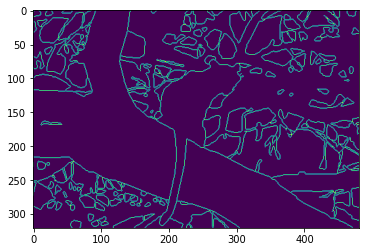

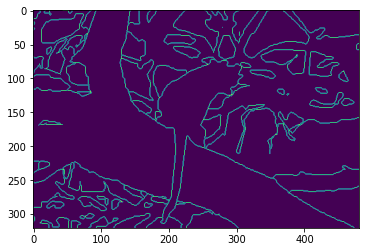

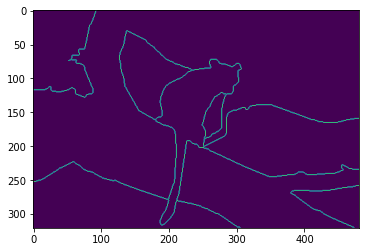

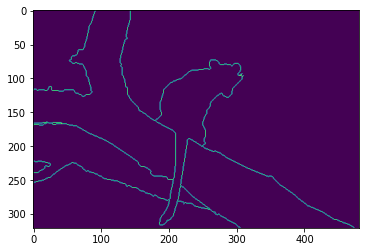

In [ ]:
Tlabels,segmented5=K_Means_Clustering(5,5)
for i in range(0,5,1):
  plt.imshow(segmented5[i])
  plt.show()   
  for j in range(0,len(data[i])):
     plt.imshow(data[i][j][1])
     plt.show() 

In [ ]:
def Spectral_Clustering(stopping_condition):
  
  if(stopping_condition==1): #4C
    C=1
  else: #4b
    C=0
  count=0
  segmented_data=[[0,222,140],[222,7,99],[50,100,190],[20,250,250],[255,77,4]]

  for f in files:
    img = cv2.imread(path+f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    w=int(0.15*img.shape[0])
    h=int(0.15*img.shape[1])
    dim=(w,h)
    img = cv2.resize(img,dim,interpolation = cv2.INTER_AREA)
    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    pixel_vals = img.reshape((-1,3))
    labels=SpectralClustering(n_clusters=5,affinity='nearest_neighbors', n_neighbors=5).fit_predict(pixel_vals)
    segmented_image=[]
    for j in range(len(labels)):
      segmented_image.append(segmented_data[labels[j]])
    segmented_image=np.array(segmented_image)
    segmented_image = segmented_image.reshape((img.shape))
    plt.imshow(segmented_image)
    plt.title(f'NCUT of  image {count+1} ')
    plt.show()
    if(C==0):
      for j in range(0,len(data[count])):
        plt.imshow(data[count][j][1])
        plt.title(f'ground truth{j} of image {count+1} ')
        plt.show() 
    count=count+1
    if(count==5):
      break

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


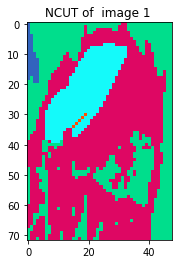

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


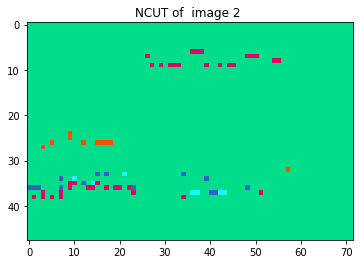

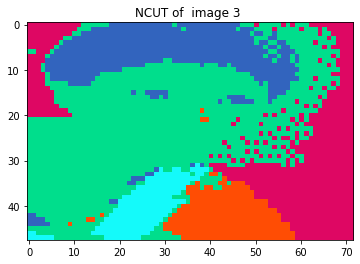

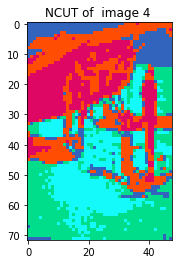

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


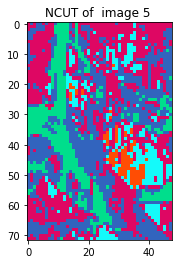

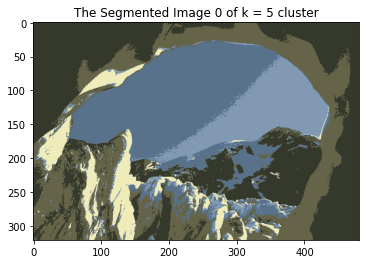

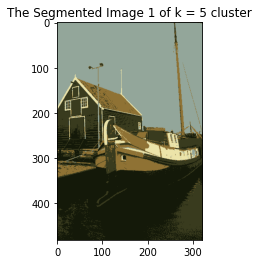

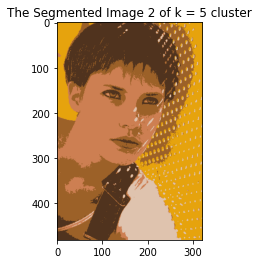

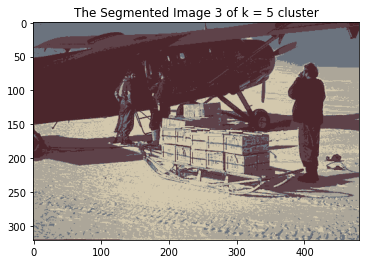

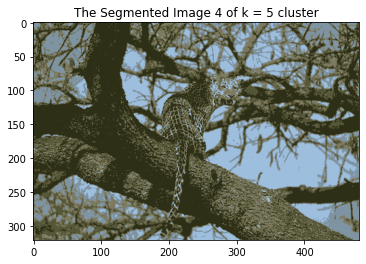

In [ ]:
Spectral_Clustering(1)
Tlabels,segmented5=K_Means_Clustering(5,5)
for i in range(5):
  plt.imshow(segmented5[i])
  plt.title(f'The Segmented Image {i} of k = 5 cluster')
  plt.show()   

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


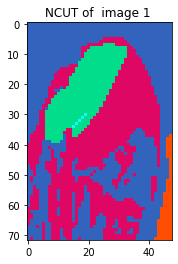

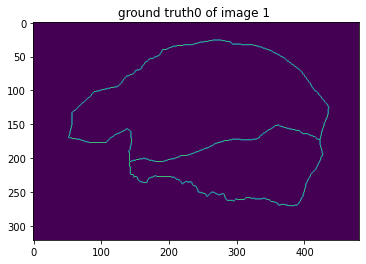

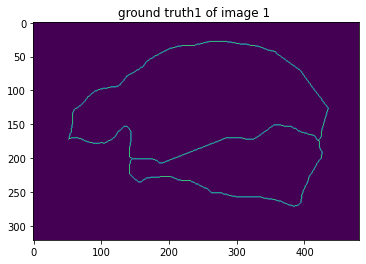

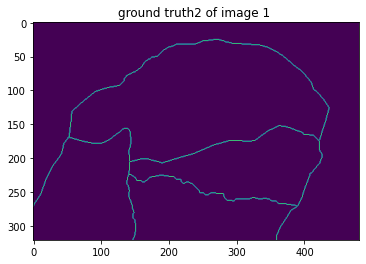

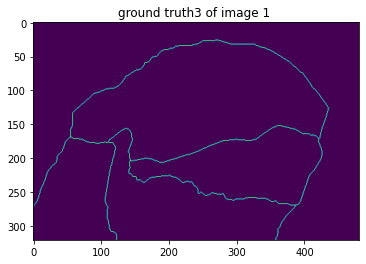

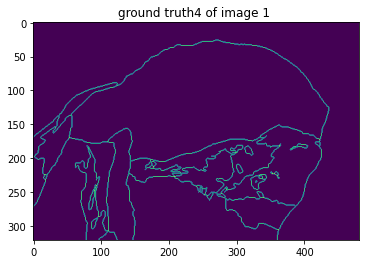

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


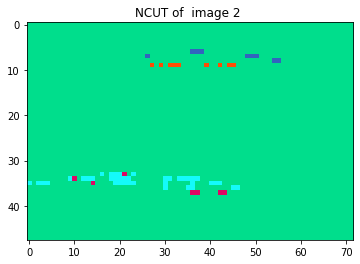

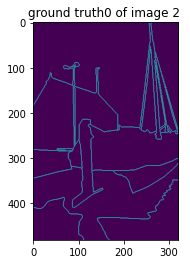

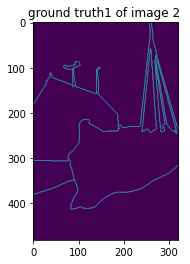

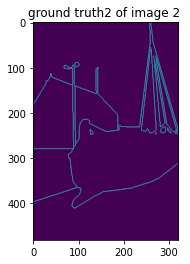

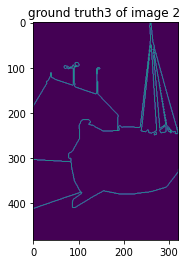

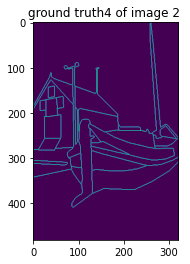

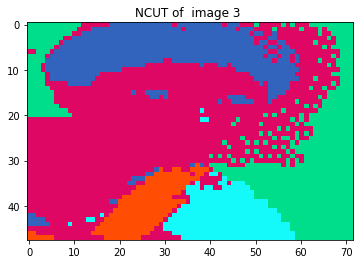

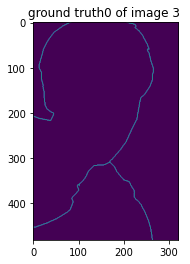

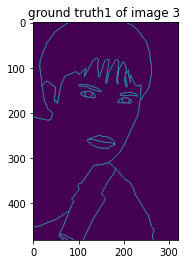

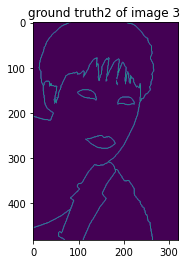

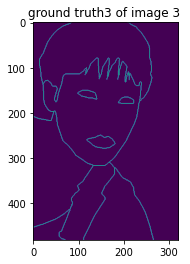

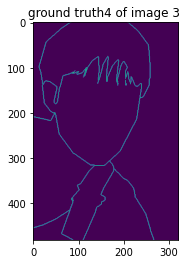

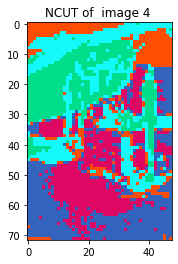

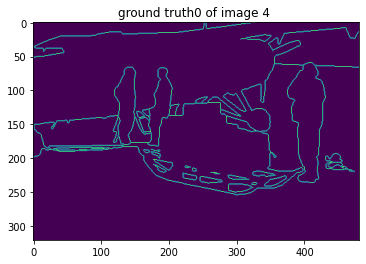

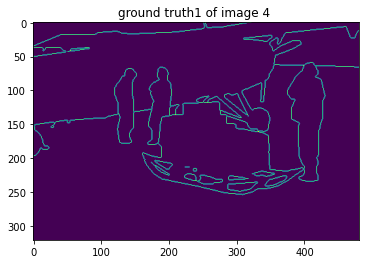

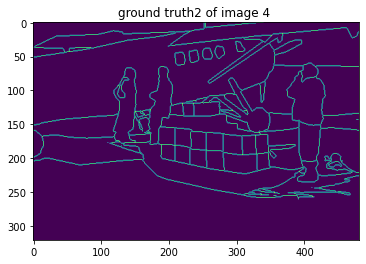

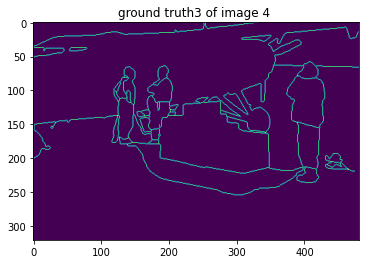

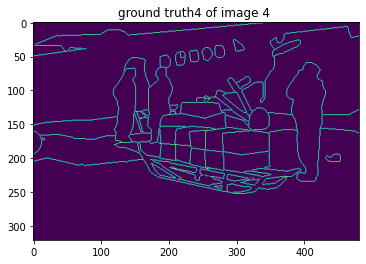

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


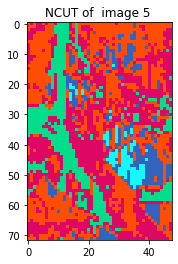

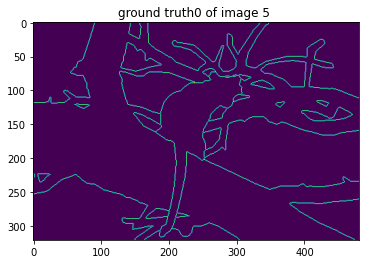

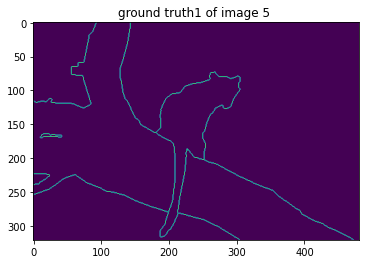

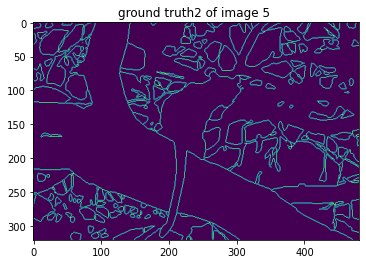

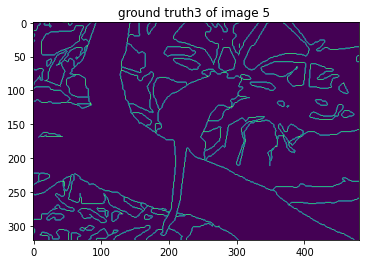

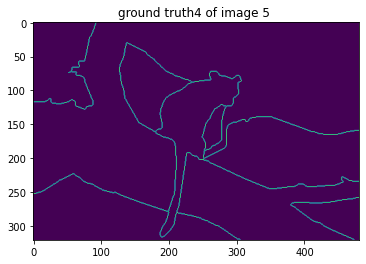

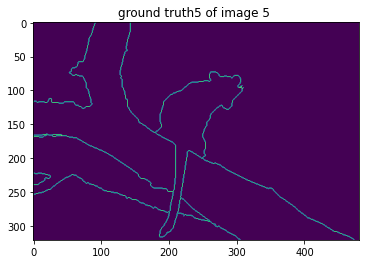

In [ ]:
Spectral_Clustering(0)

# **5. Extra**

Data:0


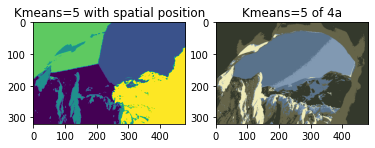

Data:1


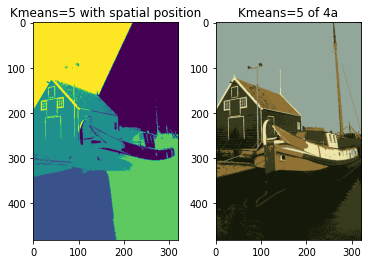

Data:2


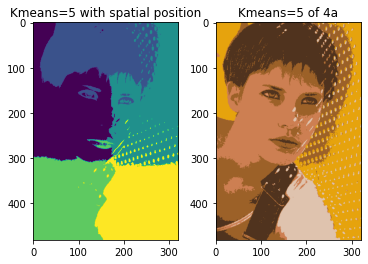

Data:3


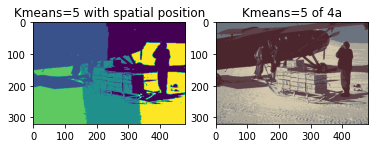

Data:4


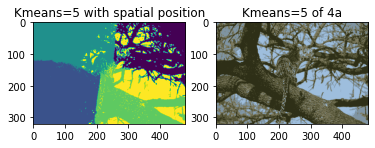

<Figure size 432x288 with 0 Axes>

In [ ]:
labelsextra=[]
count=0
for f in files:
  if(count>=5):
    break
  if(f!="Thumbs.db"):
    img = cv2.imread(path+f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    arr = np.array(img)
    coordinates_row=[]
    coordinates_col=[]
    for x in range(len(arr)):
      for y in range(len(arr[0])):
        coordinates_row.append((x,y))
      coordinates_col.append(coordinates_row)
      coordinates_row=[]
    arr = np.dstack((arr,coordinates_col))
    pixel_vals = arr.reshape((-1,5))
    pixel_vals = np.float32(pixel_vals)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    ret, labels, centers = cv2.kmeans(pixel_vals, 5, None,criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    labels=labels.reshape((arr.shape[0],arr.shape[1]))
    labelsextra.append(labels)
    count+=1

for k in range (0,len(labelsextra)):    
  print(f"Data:{k}")
  plt.subplot(1, 2, 1)
  plt.imshow(labelsextra[k])
  plt.title("Kmeans=5 with spatial position")
  plt.subplot(1, 2, 2)
  plt.imshow(segmented5[k])
  plt.title("Kmeans=5 of 4a")
  plt.show()  
  plt.figure()